In [11]:
import torch
from pathlib import Path
import torchvision
import data_setup_ood
import client
import os

root = Path(f"../FedAvg-client-1-server-10-center-take-2/models")

device = "cuda:2" if torch.cuda.is_available() else "cpu"
weights = torchvision.models.DenseNet121_Weights.DEFAULT
model = torchvision.models.densenet121(weights=weights).to(device)
auto_transform = weights.transforms()
model.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features = 1024, out_features = 2)
    )

model = model.to(device)

total_client_num = len(next(os.walk(root))[1])

client_num = 0
_, _, test_dataloader = data_setup_ood.create_dataloaders(auto_transform)
loss_fn = torch.nn.CrossEntropyLoss()

# print(total_client_num)

for client_num in range(total_client_num-1):
    client_path = root/f"client-{client_num}/"
    _,_,files = next(os.walk(client_path))
    num_epochs = len(files)
    model_path = client_path/f"epoch-{num_epochs-1}.pt"
    model.load_state_dict(torch.load(model_path))


    test_loss, test_acc = client.test_step(
        model = model,
        loss_fn=loss_fn,
        test_dataloader=test_dataloader[0],
        device = device
    )
    print(f"Client-{client_num} | Test Loss: {test_loss:.4f} | Test Accuracy: f{test_acc:.4f} ")
    # print(test_loss, test_acc)


Client-0 | Test Loss: 2.2423 | Test Accuracy: f0.6899 
Client-1 | Test Loss: 1.2308 | Test Accuracy: f0.7782 
Client-2 | Test Loss: 9.3142 | Test Accuracy: f0.4028 
Client-3 | Test Loss: 2.1021 | Test Accuracy: f0.6227 


In [12]:
client_path = root/f"server/"
_,_,files = next(os.walk(client_path))
num_epochs = len(files)
model_path = client_path/f"epoch-{num_epochs-1}.pt"
model.load_state_dict(torch.load(model_path))


test_loss, test_acc = client.test_step(
    model = model,
    loss_fn=loss_fn,
    test_dataloader=test_dataloader[0],
    device = device
)
print(f"Server | Test Loss: {test_loss:.4f} | Test Accuracy: f{test_acc:.4f} ")


Server | Test Loss: 3.4389 | Test Accuracy: f0.4150 


In [1]:
import data_setup_ood
import torchvision

train, val, test = data_setup_ood.create_dataloaders(torchvision.transforms.ToTensor())

In [48]:
import data_setup_ood_10
import torchvision
import matplotlib.pyplot as plt
tr, val, te = data_setup_ood_10.create_dataloaders(torchvision.transforms.ToTensor())

In [49]:
len(tr), len(val), len(te)

(8, 8, 2)

In [28]:
def show_image(img_tensor, title=None):
    """
    Display a tensor as an image.
    
    Parameters:
    - img_tensor (torch.Tensor): The image tensor in CHW format.
    - title (str): Optional title for the image.
    """
    # Convert the tensor to HWC format and then to a NumPy array
    img = img_tensor.permute(1, 2, 0).numpy()
    
    # If the image has 1 channel, convert it to 3 channels by repeating the image
    if img.shape[2] == 1:
        img = np.repeat(img, 3, axis=2)
    
    # Display the image
    plt.figure()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [40]:
(img, label) = next(iter(val[1]))

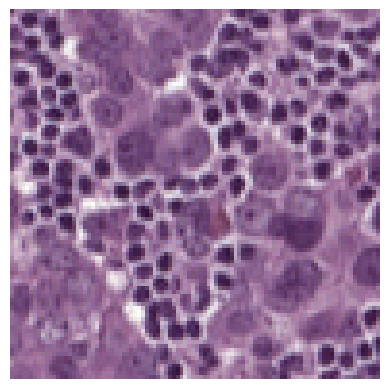

In [46]:
show_image(img[4])

In [2]:
import data_setup_random_10
import torchvision
a, b, c = data_setup_random_10.create_dataloaders(torchvision.transforms.ToTensor())

In [4]:
len(a[0]), len(b[0]), len(c[0])

(1140, 285, 1425)

In [8]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm


root_dir = "../new-paradigm/new-10-client-1-server-10-ood-2-dark-untrained-Adam/models"
path = Path(root_dir)
client_paths = [path/f"client-{i}" for i in range(8)]
server_path = path/"server"
distribution_clients = [0,1,2,3,4, 5, 6, 7]
test_clients = [0,1,2,3,4,5,6,7]
server_path = path/"server"
_,_,files = next(os.walk(client_paths[0]))
num_epochs = len(files)
device1 = "cuda:4" if torch.cuda.is_available() else 'cpu'
device2 = "cuda:4" if torch.cuda.is_available() else 'cpu'
# pca_percent_variation = 0.95


In [9]:


class MahalanobisDistance:
    def __init__(self, device1, device2):
        self.device1 = device1
        self.device2 = device2

    def _mahalanobis(self, x_test, x_mean, cov, device):
        # print(cov.shape)
        cov2 = cov.to(device)
        L = torch.linalg.cholesky(cov2)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        mdis = torch.linalg.solve(L, test_data.T)
        return torch.linalg.norm(mdis, dim=0)
    
    def _mahalanobis_approx(self, x_test, x_mean, cov, device):
        cov2 = cov.to(device)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        return torch.mm(test_data, torch.mm(torch.linalg.pinv(cov2), test_data.T))

    def mahalanobis(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        
        train_cov = torch.cov(train_data.T)
        if(train_cov.shape == torch.Size([])):
            train_cov = train_cov.reshape(1,1)
        
        return self._mahalanobis(test_data, train_mean, train_cov, self.device2)
    
    def mahalanobis_approx(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        train_cov = torch.cov(train_data.T)
        if(train_cov.shape == torch.Size([])):
            train_cov = train_cov.reshape(1,1)
        return self._mahalanobis_approx(test_data, train_mean, train_cov, self.device2)
    
    def pca_transform(self, train_data, test_data, percent_variation):
        if torch.is_tensor(train_data):
            train_data = train_data.to('cpu').numpy()
        if torch.is_tensor(test_data):
            test_data = test_data.to('cpu').numpy()

        scalar = StandardScaler()
        scalar.fit(train_data)
        train_data = scalar.transform(train_data)
        test_data = scalar.transform(test_data)

        pca = PCA(percent_variation)
        pca.fit(train_data)
        train_data = pca.transform(train_data)
        test_data = pca.transform(test_data)

        train_data = torch.tensor(train_data).to(self.device1)
        test_data = torch.tensor(test_data).to(self.device2)

        return train_data, test_data, pca


In [10]:
pca_percent_variation = 0.95
fin_mahal = {}
for epoch in range(1, num_epochs):
    client_models = [torch.load(client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(client_paths))]            
    prev_server_model = torch.load(server_path/f"epoch-{epoch-1}.pt", map_location='cpu')
    keys = list(prev_server_model.keys())
    mahal_dis = {}
    for key in keys:
        if "conv" not in key:
            continue
        
        mahal_dis[key] = {}
        

        for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]

        temp_m = {}
        used_channels = 0
        for in_channel in range(client_models[0][key].shape[1]):
            try:
                train_data, test_data = [], []

                num_samples_per_client = client_models[0][key].shape[0]

                for i in distribution_clients:
                    train_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())

                for i in test_clients:
                    test_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())
                    
                        
                train_data = np.array(train_data).astype(np.float64)
                test_data = np.array(test_data).astype(np.float64)
                

                
                train_data = train_data.reshape(train_data.shape[0], -1)
                test_data = test_data.reshape(test_data.shape[0], -1)
                # print(train_data.shape, end = " ")
                m = MahalanobisDistance(device1, device2)

                # train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data, percent_variation=pca_percent_variation)
                train_data, test_data = torch.tensor(train_data), torch.tensor(test_data)
                # print(key)
                # print(train_data.shape, test_data.shape)
                # print(pca.n_components_)
                # print(train_data.shape, test_data.shape)
                mahal = m.mahalanobis(train_data, test_data)

                # print(key, mahal)

                

                # for (key, value) in mahal:
                #     if key in temp_m.keys():
                #         temp_m[key] += value
                #     else:
                #         temp_m[key] = value
                # temp = mahal.shape

                for i in range(len(test_clients)):
                    client = test_clients[i]
                    if i in temp_m.keys():
                        # print(key)
                        temp_m[client] += torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                    else:
                        temp_m[client] = torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                
                used_channels += 1
            except:
                # print(key, in_channel)
                continue
            # break

        # print(used_channels, client_models[0][key].shape[1])

        for (i, j) in temp_m.items():
            mahal_dis[key][i] = j/used_channels

    fin_mahal[epoch] = mahal_dis
    # break

In [11]:
fin_mahal

{5: {'features.conv0.weight': {0: 6.170665202433532,
   1: 4.921863327435624,
   2: 4.4079325959740085,
   3: 3.0306010962148533,
   4: 5.608216239180938,
   5: 5.131812274367808,
   6: 4.462087790359862,
   7: 3.3875833678350324},
  'features.denseblock1.denselayer1.conv1.weight': {0: 0.7181239624994792,
   1: 0.5937240771683638,
   2: 0.6107160428965656,
   3: 0.39504107238315544,
   4: 0.6564157380879236,
   5: 0.5840699445674398,
   6: 0.6240640255958705,
   7: 0.4334515793628267},
  'features.denseblock1.denselayer1.conv2.weight': {0: 2.565949426647983,
   1: 1.7920962631913162,
   2: 1.702985768290189,
   3: 3.2594872285940464,
   4: 2.254089475036203,
   5: 1.7408951162187754,
   6: 1.8532431288298763,
   7: 3.4815317482744033},
  'features.denseblock1.denselayer2.conv1.weight': {0: 0.6890095326304503,
   1: 0.5961716846929768,
   2: 0.573579304069228,
   3: 0.6257269290678317,
   4: 0.6184761661586607,
   5: 0.5914390757919824,
   6: 0.5395208253045821,
   7: 0.6483749065943389

In [44]:
mahal_dis

{'features.conv0.weight': {0: 3.7200600654202134,
  1: 3.0982531523108383,
  2: 7.720643702104851,
  3: 6.5436424657242105,
  4: 3.9974786530428283,
  5: 3.479683075708115,
  6: 7.718736616808981,
  7: 5.521839488424431}}

In [151]:
key = "features.denseblock1.denselayer1.conv1.weight"
# tr.shape , te.shape

In [173]:
client_models[0][key][:,32]

tensor([[[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]]

In [26]:
client_models[4][key].shape

torch.Size([64, 1, 3, 7, 7])

In [19]:
key = list(client_models[0].keys())[0]

'features.conv0.weight'

In [115]:
torch.cov(torch.tensor([[0],[1],[2]]).T)

tensor(1.)

In [17]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-random-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [19]:
mahal_dis[9]

{'features.conv0.weight': {0: 4.945792257042762,
  1: 5.023909971057165,
  2: 4.385430939339947,
  3: 3.7898744953491286,
  4: 4.10426794278786,
  5: 3.367623775517476,
  6: 3.984928833950169,
  7: 3.8999012491491065},
 'features.denseblock1.denselayer1.conv1.weight': {0: 0.5280737742666087,
  1: 0.8396251705049598,
  2: 0.6955969264264575,
  3: 0.4809296326575862,
  4: 0.717722903153364,
  5: 0.44572199150322994,
  6: 0.7135343845501917,
  7: 0.6548327953631692},
 'features.denseblock1.denselayer1.conv2.weight': {0: 2.4945538523222166,
  1: 2.6625553163343176,
  2: 2.5666260250545667,
  3: 2.6090651714849997,
  4: 2.816492186268174,
  5: 2.4764885185805676,
  6: 1.955108756078941,
  7: 2.928201348715951},
 'features.denseblock1.denselayer2.conv1.weight': {0: 0.6374480321746119,
  1: 0.7763254337024603,
  2: 0.6755059823022787,
  3: 0.57766216834641,
  4: 0.701196107342137,
  5: 0.5489538776287737,
  6: 0.6674961583386866,
  7: 0.7410781736638138},
 'features.denseblock1.denselayer2.co

## CENTER

In [4]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [6]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 148.50712310771465, 1: 113.81168308590506, 2: 163.21107199834304, 3: 214.0502134356924, 4: 131.12178837741914, 5: 119.89533462569642, 6: 164.25767449962194, 7: 176.5193204014437}
{0: 119.89801584722653, 1: 96.64686835967515, 2: 159.64028522969076, 3: 159.5436915609328, 4: 129.6107648690462, 5: 85.25168080387539, 6: 177.42829884279868, 7: 187.71967754548245}
{0: 129.87026287106454, 1: 85.06302338458245, 2: 204.10540749274094, 3: 149.0482794365526, 4: 132.196025903985, 5: 89.68139574724194, 6: 167.01482952224447, 7: 145.14818069304056}
{0: 171.63096900750523, 1: 97.17065545945914, 2: 177.44354501157088, 3: 151.06607679282735, 4: 168.08963493921007, 5: 87.16973122189007, 6: 168.4174421330395, 7: 144.201239983366}
{0: 121.33875091356867, 1: 101.38513166913918, 2: 187.21011792593106, 3: 150.70523514507403, 4: 138.55688574129212, 5: 109.46857017019876, 6: 192.26420398440476, 7: 155.50832426640252}
{0: 173.53863464386035, 1: 98.44877849281734, 2: 176.90046907063368, 3: 145.15742865491976,

In [7]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-untrained-Adam/euclid_dis_all_distribution_inchannelwise.pt")
euclid_dis = torch.load(path, map_location='cpu')

In [9]:
for epoch in range(1, len(euclid_dis)):
    ans = {}
    for(key, value) in euclid_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 3.4623422012156073, 1: 3.1613118249042187, 2: 3.696003095688903, 3: 4.484238355240051, 4: 3.3112080213437065, 5: 3.1062975895876406, 6: 3.7048706034234176, 7: 4.005017063385983}
{0: 2.599203467465288, 1: 2.3963456193382813, 2: 3.053136295186095, 3: 3.1830554041594405, 4: 2.706190600045697, 5: 2.3137084421219476, 6: 3.161704062381232, 7: 3.564073771095895}
{0: 2.766094035787938, 1: 2.352877879310093, 2: 3.494831640410116, 3: 3.3071930133110414, 4: 2.6758215567982533, 5: 2.390022109236212, 6: 3.1997757045014352, 7: 3.2047836803171634}
{0: 3.5363053466439336, 1: 2.853177847745288, 2: 3.685972320830879, 3: 3.7182819912343037, 4: 3.3761687062432766, 5: 2.7379257671378787, 6: 3.6450337148796277, 7: 3.594125609954305}
{0: 2.9395100917192805, 1: 2.8721442184413792, 2: 3.8303418979016017, 3: 3.613764038907191, 4: 3.213765633644644, 5: 2.931664449958046, 6: 3.8800356619783836, 7: 3.66299262649737}
{0: 3.6514214670022196, 1: 3.014714200152028, 2: 3.9665250568168076, 3: 3.7347172435236176, 4: 

In [1]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 637.9466188794834, 1: 632.0162864345714, 2: 642.5006090073964, 3: 658.2598365886122, 4: 636.5192247586748, 5: 627.890925212712, 6: 638.632927660492, 7: 663.0275932321163}
{0: 638.9487394602008, 1: 627.1936689473333, 2: 652.7349240975486, 3: 646.8083685506238, 4: 630.9452363699586, 5: 626.6323188880622, 6: 657.2143711957867, 7: 654.433895735266}
{0: 642.2482640426609, 1: 626.0345880986991, 2: 662.5046919517675, 3: 632.6682558910363, 4: 632.2301154867032, 5: 619.943324348822, 6: 639.6751131029713, 7: 634.6008399994971}
{0: 659.2139732113708, 1: 627.8273792851079, 2: 644.1301582930528, 3: 641.3227010450462, 4: 651.9171805543923, 5: 622.2603032144153, 6: 640.8531878612328, 7: 636.5707774419085}
{0: 637.5039474776494, 1: 623.6780982000372, 2: 644.8779890909058, 3: 625.3492404854176, 4: 623.3074738591398, 5: 616.187061443631, 6: 645.1525068078465, 7: 633.4344957241972}
{0: 640.8774775660277, 1: 625.9560397732256, 2: 641.3226295741524, 3: 632.1523344492703, 4: 626.8903174057258, 5: 620.11

## OOD

In [10]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [11]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 124.49856608498409, 1: 107.00610929766694, 2: 258.43506400752574, 3: 150.9134041730823, 4: 121.88966116751588, 5: 110.59118691800026, 6: 200.7947635151088, 7: 128.97988709734216}
{0: 112.52192007506049, 1: 75.64864726348004, 2: 215.66209636416522, 3: 135.75708436369288, 4: 102.99239061222654, 5: 78.35847755659185, 6: 197.92772477991755, 7: 173.49926637454826}
{0: 124.37013629437058, 1: 88.43728638641488, 2: 196.3725569965459, 3: 151.18523144246046, 4: 106.56973113675757, 5: 85.17640875589585, 6: 208.6998722881615, 7: 149.7966046996488}
{0: 113.91906111680544, 1: 99.28410895518786, 2: 204.95604292727035, 3: 160.66464397034002, 4: 119.87789781176757, 5: 91.33929947249509, 6: 193.28452930858882, 7: 151.98464440506464}
{0: 123.77814404012827, 1: 98.80716059455789, 2: 191.50594707496748, 3: 167.46015375089237, 4: 126.5017606743216, 5: 100.45598202427777, 6: 186.40311354701387, 7: 163.97540409728998}
{0: 145.1393359582746, 1: 95.31677215827119, 2: 184.88259848751642, 3: 156.1122660570716

In [16]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-untrained-Adam/euclid_dis_all_distribution_inchannelwise.pt")
euclid_dis = torch.load(path, map_location='cpu')

In [17]:
for epoch in range(1, len(euclid_dis)):
    ans = {}
    for(key, value) in euclid_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 3.536251065732519, 1: 3.159379957998882, 2: 4.98142055510397, 3: 4.003021867268193, 4: 3.4128130462553417, 5: 3.2663235764534715, 6: 4.3715538878519045, 7: 3.829830382918672}
{0: 3.430139610798177, 1: 3.008016625759626, 2: 4.768539826226022, 3: 4.145851471320706, 4: 3.429090923320689, 5: 3.029439680774852, 6: 4.737460370200728, 7: 4.533031144407936}
{0: 3.1828198350127224, 1: 2.8580721414522876, 2: 4.146048199865074, 3: 3.7939284209294954, 4: 2.9922871684778753, 5: 2.796574072533928, 6: 4.301880012582957, 7: 3.769940527007488}
{0: 2.9976447055756226, 1: 2.8601705921662135, 2: 4.18678192964718, 3: 3.7064575159220983, 4: 3.02791748230193, 5: 2.773659418885908, 6: 3.9707392799949646, 7: 3.6136769196476344}
{0: 3.081328728428241, 1: 2.858582570474765, 2: 4.008503109852433, 3: 3.7443798563515793, 4: 3.1184263119112052, 5: 2.890910564076362, 6: 3.8763607354802265, 7: 3.6380168698637925}
{0: 3.203741433428836, 1: 2.8335568820888226, 2: 3.8974140824909975, 3: 3.646759423968352, 4: 3.152424

In [2]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 637.487413941608, 1: 636.538257852432, 2: 655.6382623749878, 3: 641.1617763203667, 4: 643.4698294141101, 5: 630.4796039266563, 6: 644.6027307326914, 7: 648.420355387674}
{0: 639.7744184983037, 1: 630.2544146093505, 2: 659.523205594937, 3: 641.3054388926473, 4: 637.8132949624032, 5: 628.4423190052673, 6: 660.4565454280688, 7: 640.1723856126711}
{0: 635.3497425503231, 1: 630.345845338927, 2: 665.5998582227826, 3: 644.339146993189, 4: 630.5325583768615, 5: 627.6820808537618, 6: 664.9864983799728, 7: 638.1573248891044}
{0: 631.7601300582776, 1: 638.115821287383, 2: 671.8256572571887, 3: 638.7797644388032, 4: 631.4169613942389, 5: 636.8449722313973, 6: 652.8692877433423, 7: 635.9541571855291}
{0: 641.5005030279582, 1: 626.305613794608, 2: 647.1131680442712, 3: 651.3546852455139, 4: 631.5903560449342, 5: 626.4119695172536, 6: 646.2156172628733, 7: 652.3391628084531}
{0: 642.1169988181573, 1: 627.9204741981866, 2: 648.9567466945277, 3: 642.5183126153646, 4: 635.2182004262667, 5: 622.41773

# OOD DARK

In [14]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-dark-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [15]:
mahal_dis[6]

{'features.conv0.weight': {0: 6.555093249597533,
  1: 5.732247380645802,
  2: 3.7830722517118414,
  3: 2.3352420591120673,
  4: 6.342007691462373,
  5: 4.730202946954181,
  6: 4.883080786139764,
  7: 2.158422233764449},
 'features.denseblock1.denselayer1.conv1.weight': {0: 0.6526041109278103,
  1: 0.6848730754624174,
  2: 0.5131288046481219,
  3: 0.25850926661553086,
  4: 0.5715416303315504,
  5: 0.5680628486864026,
  6: 0.7341939724538469,
  7: 0.2701164566696804},
 'features.denseblock1.denselayer1.conv2.weight': {0: 2.3450381778542853,
  1: 1.8845324065683222,
  2: 2.0228419207829433,
  3: 3.1616607619045776,
  4: 2.4497280632240943,
  5: 1.7629249815815666,
  6: 2.045260681865508,
  7: 3.2055820820720866},
 'features.denseblock1.denselayer2.conv1.weight': {0: 0.6011270669027117,
  1: 0.6213824505134102,
  2: 0.5849119464187191,
  3: 0.5176405592439925,
  4: 0.5628725849205606,
  5: 0.5542555883860415,
  6: 0.6717330838421163,
  7: 0.5267867267431551},
 'features.denseblock1.densela

In [28]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 131.92082680455724, 1: 102.24285722018885, 2: 199.18964976980655, 3: 158.82853381236035, 4: 149.89229688762407, 5: 92.73245556360278, 6: 205.40526072326824, 7: 184.87985785627615}
{0: 132.77583565084242, 1: 92.86775991595744, 2: 156.3425690328585, 3: 157.71717683613, 4: 149.26995626838024, 5: 114.67063382095161, 6: 168.67954310743553, 7: 162.49710409004908}
{0: 138.78981436312864, 1: 93.12204481810102, 2: 152.79106790708462, 3: 147.9712586226194, 4: 158.20143914303625, 5: 87.21359114954092, 6: 163.11727063726465, 7: 157.2411352247793}
{0: 161.3817882805687, 1: 96.83077228121884, 2: 156.07073390100769, 3: 148.58972247280778, 4: 142.9698063647777, 5: 97.1735570189448, 6: 157.18736271817974, 7: 143.1221429836921}
{0: 145.68854287005783, 1: 105.165255290811, 2: 154.77103311991812, 3: 139.10206883753668, 4: 146.35781888597168, 5: 111.53877917682189, 6: 153.18508134082495, 7: 144.425276898653}
{0: 141.72415093879113, 1: 107.40356389508862, 2: 149.71678154605203, 3: 138.08114755015396, 4:

In [19]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-dark-untrained-Adam/euclid_dis_all_distribution_inchannelwise.pt")
euclid_dis = torch.load(path, map_location='cpu')

In [20]:
for epoch in range(1, len(euclid_dis)):
    ans = {}
    for(key, value) in euclid_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 3.700581273505133, 1: 3.425990752446986, 2: 4.7544452319077966, 3: 4.316054326578118, 4: 4.05045147205762, 5: 3.377209533575028, 6: 5.066242493652424, 7: 4.715322441599746}
{0: 3.455492898143824, 1: 2.989308611351417, 2: 3.8522464455918493, 3: 3.930673642492558, 4: 3.441171983283266, 5: 3.0966671586323975, 6: 3.9454940890772336, 7: 4.001926018318433}
{0: 3.0599064643615117, 1: 2.7165570693623087, 2: 3.476358898481572, 3: 3.556006891081163, 4: 3.2391578130678615, 5: 2.658168626754452, 6: 3.5464067705521454, 7: 3.64712969952131}
{0: 3.0466446186808795, 1: 2.6588076968328465, 2: 3.505307452030791, 3: 3.3696455764589284, 4: 3.004761532587869, 5: 2.628357602934094, 6: 3.422037388724252, 7: 3.340780456511277}
{0: 2.998481667159711, 1: 2.638401882597146, 2: 3.2723215163204133, 3: 3.228410071726348, 4: 2.9931173628464154, 5: 2.685954326817705, 6: 3.3047180661051128, 7: 3.2769119194785747}
{0: 2.938744664288183, 1: 2.635838289607616, 2: 3.2881303248114304, 3: 3.1874094123276104, 4: 2.865125

In [3]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-dark-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 641.9082698745216, 1: 632.8233687210662, 2: 645.693333149557, 3: 648.8630075387313, 4: 648.3269743010272, 5: 627.3227189339885, 6: 644.4925324442869, 7: 648.2934236635123}
{0: 639.6329141627432, 1: 619.0560258083196, 2: 647.490477988435, 3: 638.167521342708, 4: 654.5646342606982, 5: 646.8388090122478, 6: 632.1498940489746, 7: 636.7820762603884}
{0: 646.3656532310856, 1: 608.3785998881216, 2: 641.5065539857969, 3: 614.7287483116328, 4: 646.7425920157883, 5: 608.5380809566644, 6: 642.0725644107279, 7: 619.670871877518}
{0: 692.3906803661802, 1: 615.3037731760002, 2: 630.0671577014537, 3: 624.9652835028061, 4: 624.0157501844856, 5: 612.3835816915207, 6: 645.4254730559421, 7: 619.7750194056525}
{0: 628.0641626245274, 1: 621.9919363646973, 2: 649.5997303526252, 3: 623.90966544561, 4: 623.9789034642371, 5: 610.0920170977413, 6: 651.2688553119968, 7: 625.3190025883976}
{0: 662.1278329015234, 1: 619.1987524305327, 2: 661.1750698034995, 3: 621.6036136945079, 4: 619.72525735049, 5: 618.94626

## RANDOM

In [21]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-random-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [22]:
mahal_dis[6]

{'features.conv0.weight': {0: 3.324952289687225,
  1: 4.744952351373233,
  2: 4.540478667513448,
  3: 3.925326267750304,
  4: 4.543184624698703,
  5: 4.2594536588651515,
  6: 4.641947798100424,
  7: 4.237722027628859},
 'features.denseblock1.denselayer1.conv1.weight': {0: 0.397090263643241,
  1: 0.7078374319089658,
  2: 0.6239301861720012,
  3: 0.5504925887802442,
  4: 0.7049306541518091,
  5: 0.5864867851346287,
  6: 0.646492019665179,
  7: 0.7212277651458057},
 'features.denseblock1.denselayer1.conv2.weight': {0: 2.4300530184034916,
  1: 2.507999589606439,
  2: 2.4171821575308585,
  3: 2.625735639418262,
  4: 2.5617355329948004,
  5: 2.4843528039757223,
  6: 2.435222611980785,
  7: 2.890131799200284},
 'features.denseblock1.denselayer2.conv1.weight': {0: 0.5145231426219561,
  1: 0.6808204194078018,
  2: 0.5699219779725614,
  3: 0.6089791955330622,
  4: 0.7148041955112214,
  5: 0.628577841046625,
  6: 0.6640480717766489,
  7: 0.726022159570952},
 'features.denseblock1.denselayer2.conv

In [23]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 181.2277624453552, 1: 162.11882245171537, 2: 139.36018832060407, 3: 153.9698995802173, 4: 170.52401851018695, 5: 96.19655071801692, 6: 147.74045237016122, 7: 149.03387219300552}
{0: 137.7299696721612, 1: 140.08951933229122, 2: 131.1341259130448, 3: 138.1739052480355, 4: 134.2382965060741, 5: 177.24642287597058, 6: 134.1820878102115, 7: 130.52304460964646}
{0: 125.12104420247873, 1: 132.6531525663509, 2: 130.45403304912807, 3: 124.56181171566429, 4: 126.7359589414262, 5: 123.02471599386648, 6: 185.5221828298616, 7: 116.15066192770658}
{0: 119.42706846593487, 1: 125.29122793592477, 2: 129.73029832730418, 3: 133.5123275846353, 4: 127.49317131300039, 5: 125.98722976146013, 6: 131.1276831071234, 7: 170.9307089423833}
{0: 148.05463462010894, 1: 137.94451297384933, 2: 133.12536186636237, 3: 133.52482222964753, 4: 131.29110758526093, 5: 138.70525436298925, 6: 127.90874952467217, 7: 121.05423509939884}
{0: 136.1587668064253, 1: 121.89930545644934, 2: 125.68669485584971, 3: 113.8282380083681

In [25]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-random-untrained-Adam/euclid_dis_all_distribution_inchannelwise.pt")
euclid_dis = torch.load(path, map_location='cpu')

In [26]:
for epoch in range(1, len(euclid_dis)):
    ans = {}
    for(key, value) in euclid_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 3.4688396179629484, 1: 3.125902624701931, 2: 2.9327328048582864, 3: 3.1351956527290614, 4: 3.1851615536405165, 5: 2.446506938287628, 6: 2.9556728646018757, 7: 3.013908375466504}
{0: 2.21275290059935, 1: 2.2317785830759047, 2: 2.1765043618304976, 3: 2.22141847361279, 4: 2.206319282644163, 5: 2.3535030474903813, 6: 2.0770558727823456, 7: 2.174634294368076}
{0: 2.3632392941878058, 1: 2.451490675207027, 2: 2.4651630108363913, 3: 2.417375528382051, 4: 2.441138621317647, 5: 2.376452607362616, 6: 2.674948474518947, 7: 2.3360821885975267}
{0: 2.266700119254096, 1: 2.322801132492926, 2: 2.3771132558509698, 3: 2.41165500041044, 4: 2.354245057441869, 5: 2.3621480536476067, 6: 2.3851847676127913, 7: 2.4888356489530215}
{0: 2.378078739660246, 1: 2.366772957053853, 2: 2.2635270909515848, 3: 2.2745565643566534, 4: 2.2847420176427984, 5: 2.3330639092336196, 6: 2.3236599252292276, 7: 2.253306130164755}
{0: 2.4007377399108307, 1: 2.3634959203417902, 2: 2.3243357332422723, 3: 2.2977978756806205, 4: 2

In [4]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-random-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 670.5320816506002, 1: 647.32270154763, 2: 631.5109514923215, 3: 640.8744629639389, 4: 641.6263246278423, 5: 630.504519790175, 6: 641.2767061690022, 7: 632.3441829101868}
{0: 650.3811300768325, 1: 641.5627889124501, 2: 630.7781971580849, 3: 638.4006107268171, 4: 642.6836163171392, 5: 654.7543093777808, 6: 645.4608025700454, 7: 633.4329484337402}
{0: 603.0406850850053, 1: 619.2742426185757, 2: 608.5317148531984, 3: 608.7638295314813, 4: 606.2696724785789, 5: 607.1843082032985, 6: 714.3023361735145, 7: 599.7017290526949}
{0: 611.2290456889962, 1: 617.397491402973, 2: 613.8225231819796, 3: 612.63724525025, 4: 606.1023817738208, 5: 611.3352414301527, 6: 610.5704455465996, 7: 642.3256667118314}
{0: 625.2207844076399, 1: 606.109929972736, 2: 596.0957920513794, 3: 600.3271244871783, 4: 594.5508635794504, 5: 615.7195119816694, 6: 593.6654895353391, 7: 594.6696972540232}
{0: 608.1480326684665, 1: 599.1569685945755, 2: 609.5285788593249, 3: 598.3168811481386, 4: 604.5942087137512, 5: 592.9016

## OOD Severe

In [4]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [5]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 197.45820406060963, 1: 120.03640035505863, 2: 50.21910480538325, 3: 212.77625687879342, 4: 145.16458916720802, 5: 133.01640171543795, 6: 192.79398139120516, 7: 149.364772811219}
{0: 120.09550067832038, 1: 90.23228920296812, 2: 181.17440134480924, 3: 135.32507937308335, 4: 123.695746977763, 5: 91.62563200814026, 6: 201.9752786223066, 7: 102.25987359447343}
{0: 126.7508489345045, 1: 90.30388335618038, 2: 177.56306911838132, 3: 143.36829787947994, 4: 116.1069907536684, 5: 88.90365797764976, 6: 167.40373647260938, 7: 126.86425242209855}
{0: 114.03751492992137, 1: 87.98096714747223, 2: 174.86288717851204, 3: 148.01974013562258, 4: 121.58517276186063, 5: 88.5633088813726, 6: 188.8336556969436, 7: 150.70789343538004}
{0: 157.4062123766104, 1: 90.16594738198478, 2: 175.04627341635208, 3: 148.91934446875084, 4: 146.0206097727294, 5: 88.87907513154248, 6: 155.8192056230472, 7: 150.79873150835442}
{0: 133.0929735120099, 1: 97.86253525062756, 2: 177.819850643493, 3: 149.1363409921029, 4: 138.5

In [6]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/euclid_dis_all_distribution_inchannelwise.pt")
euclid_dis = torch.load(path, map_location='cpu')

In [7]:
for epoch in range(1, len(euclid_dis)):
    ans = {}
    for(key, value) in euclid_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 3.576015516268584, 1: 2.8060442861492225, 2: 2.246290689733905, 3: 3.8605745716569997, 4: 3.0518337397575297, 5: 2.822502514847918, 6: 3.6858183087461165, 7: 3.243570523941477}
{0: 3.1441093401347553, 1: 2.768623589096944, 2: 4.031225260461584, 3: 3.4518485202307385, 4: 3.1707189149340884, 5: 2.7617470832520663, 6: 4.266606612392253, 7: 2.9618133526998878}
{0: 3.058325367398388, 1: 2.760690045943896, 2: 4.110692248234704, 3: 3.660547571924228, 4: 2.962057319439737, 5: 2.7962565585917605, 6: 3.846329655410502, 7: 3.523167783303164}
{0: 3.0712896441768187, 1: 2.81801728480635, 2: 4.046685437260243, 3: 3.7730754495900505, 4: 3.1037771820480433, 5: 2.8336615004901162, 6: 4.040747096984718, 7: 3.872947570916855}
{0: 3.216487724782966, 1: 2.8288625711572175, 2: 3.9281179895720935, 3: 3.7750072817605935, 4: 3.2214102680414247, 5: 2.8346160313068127, 6: 3.768859587841836, 7: 3.7897819509074147}
{0: 3.0512311455651893, 1: 2.841922972450918, 2: 3.789444403719335, 3: 3.6401590911150667, 4: 3.

In [5]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 662.3890101492132, 1: 636.3708374265112, 2: 625.7262646136061, 3: 660.9940391030498, 4: 634.5148447597661, 5: 627.3325529551853, 6: 652.409119707309, 7: 636.1021693441289}
{0: 650.8795667375618, 1: 628.5742705216524, 2: 651.1071909508075, 3: 649.7121858264496, 4: 636.743344006414, 5: 622.1428296341678, 6: 655.8412995884216, 7: 636.9003043409658}
{0: 649.4147622172103, 1: 622.8966700423217, 2: 651.5015701309899, 3: 646.4568372550169, 4: 641.6718652306698, 5: 623.0718780471493, 6: 650.3698728335382, 7: 635.3722454966029}
{0: 623.1076351749127, 1: 614.1154753300752, 2: 661.0915680373233, 3: 633.3236789517499, 4: 639.9882412446125, 5: 607.0687991669156, 6: 680.9126644794807, 7: 631.913316174395}
{0: 676.2856217380422, 1: 616.6598941177965, 2: 654.8497008946651, 3: 621.943696496341, 4: 659.5746149027991, 5: 605.0820879911987, 6: 637.788882488003, 7: 613.3155525603239}
{0: 656.9512206586694, 1: 611.447358897229, 2: 659.6555946563576, 3: 628.2421935276071, 4: 650.7640365343456, 5: 620.911

## All Flat

In [9]:
import torch
l = torch.load(f = "../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/mahal_dis_all_flatten.pt", map_location = 'cpu')

In [8]:
for epoch in range(1, len(l)):
    ans = {}
    for(key, value) in l[epoch].items():
        if len(value) == 0:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 179.899874106781, 1: 149.9199144291805, 2: 226.13180505919902, 3: 287.43435680850394, 4: 186.30333901020805, 5: 147.7679731744273, 6: 226.09046770478264, 7: 270.4013449376116}
{0: 163.85544687412263, 1: 141.78702720469374, 2: 234.33030390953562, 3: 236.12085548708782, 4: 185.0798614074798, 5: 132.51768494421697, 6: 247.04953821401938, 7: 267.8590263540043}
{0: 181.58309821488447, 1: 121.65122676853652, 2: 264.2048050094646, 3: 231.47035830719847, 4: 161.6138750138645, 5: 125.24253423433237, 6: 226.26046343421356, 7: 227.51826078358548}
{0: 211.59261383156593, 1: 143.782760741265, 2: 234.2404040026592, 3: 238.99848677985452, 4: 190.08523695447613, 5: 128.784282818527, 6: 221.2376812939918, 7: 225.90380145294304}
{0: 160.742599829659, 1: 142.61667832854386, 2: 236.88120931850386, 3: 222.54284890315014, 4: 165.95281478530504, 5: 151.78680832914762, 6: 255.78136837756549, 7: 228.52090671609827}
{0: 198.31124511422115, 1: 141.4545859559165, 2: 243.33432896574797, 3: 215.97715741140556, 

In [10]:
for epoch in range(1, len(l)):
    ans = {}
    for(key, value) in l[epoch].items():
        if len(value) == 0:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 257.2955931412529, 1: 157.30546473918537, 2: 99.68086492289746, 3: 289.38411654901626, 4: 194.90342041778987, 5: 169.76885997968094, 6: 289.32245625478316, 7: 214.9124556248565}
{0: 180.73521010168835, 1: 132.3576869075762, 2: 250.1425989424266, 3: 219.44796710876486, 4: 184.5800953927113, 5: 133.47131002200376, 6: 268.4194958817367, 7: 167.19656546687344}
{0: 157.68397040888672, 1: 133.41240316639227, 2: 228.04339008873782, 3: 215.57476805920007, 4: 156.47591951914438, 5: 140.08481725346684, 6: 236.39693212562236, 7: 203.79594299404218}
{0: 144.85873702076447, 1: 127.99033568941708, 2: 239.99863169072313, 3: 216.95832653798743, 4: 151.51520703975967, 5: 128.05008624569354, 6: 244.40535900255156, 7: 219.9183008751914}
{0: 183.83691163511276, 1: 128.4811213022355, 2: 233.24373791714805, 3: 221.42747621816054, 4: 177.12281992797867, 5: 127.65933818796225, 6: 225.25996035125243, 7: 223.64641552171022}
{0: 164.65804233941594, 1: 132.46824991931356, 2: 228.63088470944655, 3: 213.6186737

In [1]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm


root_dir = "../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/models"
path = Path(root_dir)
client_paths = [path/f"client-{i}" for i in range(8)]
server_path = path/"server"
distribution_clients = [0,1,2,3,4,5,6,7]
test_clients = [0,1,2,3,4,5,6,7]
server_path = path/"server"
_,_,files = next(os.walk(client_paths[0]))
num_epochs = len(files)
device1 = "cuda:0" if torch.cuda.is_available() else 'cpu'
device2 = "cuda:0" if torch.cuda.is_available() else 'cpu'
# pca_percent_variation = 0.95


class MahalanobisDistance:
    def __init__(self, device1, device2):
        self.device1 = device1
        self.device2 = device2

    def _mahalanobis(self, x_test, x_mean, cov, device):
        # print(cov.shape)
        cov2 = cov.to(device)
        L = torch.linalg.cholesky(cov2)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        mdis = torch.linalg.solve(L, test_data.T)
        return torch.linalg.norm(mdis, dim=0)
    
    def _mahalanobis_approx(self, x_test, x_mean, cov, device):
        cov2 = cov.to(device)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        return torch.mm(test_data, torch.mm(torch.linalg.pinv(cov2), test_data.T))

    def mahalanobis(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        
        train_cov = torch.diag(torch.var(train_data, dim = 0))
        if(train_cov.shape == torch.Size([])):
            train_cov = train_cov.reshape(1,1)
        
        return self._mahalanobis(test_data, train_mean, train_cov, self.device2)
    
    def mahalanobis_approx(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        train_cov = torch.diag(torch.mean(train_data, dim=0))
        if(train_cov.shape == torch.Size([])):
            train_cov = train_cov.reshape(1,1)
        return self._mahalanobis_approx(test_data, train_mean, train_cov, self.device2)
    
    def pca_transform(self, train_data, test_data):
        if torch.is_tensor(train_data):
            train_data = train_data.to('cpu').numpy()
        if torch.is_tensor(test_data):
            test_data = test_data.to('cpu').numpy()

        scalar = StandardScaler()
        scalar.fit(train_data)
        train_data = scalar.transform(train_data)
        test_data = scalar.transform(test_data)

        pca = PCA()
        pca.fit(train_data)
        train_data = pca.transform(train_data)
        test_data = pca.transform(test_data)

        train_data = torch.tensor(train_data).to(self.device1)
        test_data = torch.tensor(test_data).to(self.device2)

        return train_data, test_data, pca


fin_mahal = {}
for epoch in range(1, num_epochs):
    client_models = [torch.load(client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(client_paths))]            
    prev_server_model = torch.load(server_path/f"epoch-{epoch-1}.pt", map_location='cpu')
    keys = list(prev_server_model.keys())
    mahal_dis = {}
    for key in keys:
        for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]
        if "conv" in key:
        
            mahal_dis[key] = {}
            


            temp_m = {}
            used_channels = 0
            for in_channel in range(client_models[0][key].shape[1]):
                try:
                    train_data, test_data = [], []

                    num_samples_per_client = client_models[0][key].shape[0]

                    for i in distribution_clients:
                        train_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())

                    for i in test_clients:
                        test_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())
                        
                            
                    train_data = np.array(train_data).astype(np.float64)
                    test_data = np.array(test_data).astype(np.float64)
                    

                    
                    train_data = train_data.reshape(train_data.shape[0], -1)
                    test_data = test_data.reshape(test_data.shape[0], -1)
                    # print(train_data.shape, end = " ")
                    m = MahalanobisDistance(device1, device2)

                    train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data)
                    if torch.count_nonzero(train_data):
                        continue
                    # train_data, test_data = torch.tensor(train_data), torch.tensor(test_data)
                    # print(key)
                    # print(train_data.shape, test_data.shape)
                    # print(pca.n_components_)
                    # print(train_data.shape, test_data.shape)
                    mahal = m.mahalanobis(train_data, test_data)

                    # print(key, mahal)

                    

                    # for (key, value) in mahal:
                    #     if key in temp_m.keys():
                    #         temp_m[key] += value
                    #     else:
                    #         temp_m[key] = value
                    # temp = mahal.shape

                    for i in range(len(test_clients)):
                        client = test_clients[i]
                        if i in temp_m.keys():
                            # print(key)
                            temp_m[client] += torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                        else:
                            temp_m[client] = torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                    
                    used_channels += 1
                except:
                    # print(key, in_channel)
                    continue
                # break

            # print(used_channels, client_models[0][key].shape[1])

            for (i, j) in temp_m.items():
                mahal_dis[key][i] = j/used_channels
        
        else:
            mahal_dis[key] = {}

            temp_m = {}
            used_channels = 0
            try:
                train_data, test_data = [], []

                num_samples_per_client = 1
                

                for i in distribution_clients:
                    train_data.extend(client_models[i][key].reshape(1, -1).numpy())

                for i in test_clients:
                    test_data.extend(client_models[i][key].reshape(1, -1).numpy())
                    
                        
                train_data = np.array(train_data).astype(np.float64)
                test_data = np.array(test_data).astype(np.float64)
                
                if torch.count_nonzero(train_data):
                    continue
                
                # print(train_data.shape, end = " ")
                m = MahalanobisDistance(device1, device2)

                train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data)
                # train_data, test_data = torch.tensor(train_data), torch.tensor(test_data)
                # print(key)
                # print(train_data.shape, test_data.shape)
                # print(pca.n_components_)
                # print(train_data.shape, test_data.shape)
                mahal = m.mahalanobis(train_data, test_data)

                # print(key, mahal)

                

                # for (key, value) in mahal:
                #     if key in temp_m.keys():
                #         temp_m[key] += value
                #     else:
                #         temp_m[key] = value
                # temp = mahal.shape

                for i in range(len(test_clients)):
                    client = test_clients[i]
                    if i in temp_m.keys():
                        # print(key)
                        temp_m[client] += torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                    else:
                        temp_m[client] = torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                
                # used_channels += 1
            except:
                # print(key, in_channel)
                continue
                # break

            # print(used_channels, client_models[0][key].shape[1])

            for (i, j) in temp_m.items():
                mahal_dis[key][i] = j


    fin_mahal[epoch] = mahal_dis
    # break

/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-pac

## New Stuff

In [7]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ana-75-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 263.61539728485667, 1: 263.61539728485667, 2: 1377.9392957620616, 3: 263.61539728485667, 4: 263.61539728485667, 5: 263.61539728485667, 6: 1428.7399610321272, 7: 263.61539728485667}
{0: 268.0969379368157, 1: 268.0969379368157, 2: 1413.1614622797476, 3: 268.0969379368157, 4: 268.0969379368157, 5: 268.0969379368157, 6: 1393.1456711826715, 7: 268.0969379368157}
{0: 262.947747580014, 1: 262.947747580014, 2: 1404.1395202303152, 3: 262.947747580014, 4: 262.947747580014, 5: 262.947747580014, 6: 1407.876887787179, 7: 262.947747580014}
{0: 261.87573383898484, 1: 261.87573383898484, 2: 1380.6190632924752, 3: 261.87573383898484, 4: 261.87573383898484, 5: 261.87573383898484, 6: 1429.8256565788704, 7: 261.87573383898484}
{0: 263.0088250306378, 1: 263.0088250306378, 2: 1414.3485861297431, 3: 263.0088250306378, 4: 263.0088250306378, 5: 263.0088250306378, 6: 1392.5643799240218, 7: 263.0088250306378}
{0: 260.1326492682854, 1: 260.1326492682854, 2: 1407.7084283208505, 3: 260.1326492682854, 4: 260.132

In [5]:
import torch
import torchvision
from torchsummary import summary

m = torchvision.models.densenet121(weights = None)

for (key , value) in m.state_dict().items():
    print(key, value.shape)

features.conv0.weight torch.Size([64, 3, 7, 7])
features.norm0.weight torch.Size([64])
features.norm0.bias torch.Size([64])
features.norm0.running_mean torch.Size([64])
features.norm0.running_var torch.Size([64])
features.norm0.num_batches_tracked torch.Size([])
features.denseblock1.denselayer1.norm1.weight torch.Size([64])
features.denseblock1.denselayer1.norm1.bias torch.Size([64])
features.denseblock1.denselayer1.norm1.running_mean torch.Size([64])
features.denseblock1.denselayer1.norm1.running_var torch.Size([64])
features.denseblock1.denselayer1.norm1.num_batches_tracked torch.Size([])
features.denseblock1.denselayer1.conv1.weight torch.Size([128, 64, 1, 1])
features.denseblock1.denselayer1.norm2.weight torch.Size([128])
features.denseblock1.denselayer1.norm2.bias torch.Size([128])
features.denseblock1.denselayer1.norm2.running_mean torch.Size([128])
features.denseblock1.denselayer1.norm2.running_var torch.Size([128])
features.denseblock1.denselayer1.norm2.num_batches_tracked torc

In [1]:
import torch
from pathlib import Path

dirs = [
    "../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/models",
    "../new-paradigm/new-10-client-1-server-10-ana-10-untrained-Adam/models",
    "../new-paradigm/new-10-client-1-server-10-ana-25-untrained-Adam/models",
    "../new-paradigm/new-10-client-1-server-10-ana-50-untrained-Adam/models",
    "../new-paradigm/new-10-client-1-server-10-ana-75-untrained-Adam/models",
    "../new-paradigm/new-10-client-1-server-10-sfa-untrained-Adam/models",
    # "../new-paradigm/new-10-client-1-server-10-untrained-Adam/models",
    # "../new-paradigm/new-10-client-1-server-10-random-untrained-Adam/models",
]


In [6]:
root_dir = Path(dirs[0])
cmp = torch.load(root_dir/"../comparison.pt", map_location = 'cpu')
mahal = torch.load(root_dir/"../mahal_dis_all_pca.pt")
euclid = torch.load(root_dir/"../euclidean_dis_fin.pt")
cosine = torch.load(root_dir/"../cosine_dis_fin.pt")

In [8]:
cmp[6]['mahal/cosine']

{'features.conv0.weight': {0: 5.072354311074596,
  1: 4.84640221520467,
  2: 6.624250727939275,
  3: 3.014558489383477,
  4: 6.139827569354735,
  5: 4.089499062469542,
  6: 6.158250175632199,
  7: 3.387836543201984},
 'features.norm0.weight': {0: 4.123464695273941,
  1: 3.3720798270477568,
  2: 3.557783364552336,
  3: 3.756040441821942,
  4: 3.9475912130565107,
  5: 3.9378764273582014,
  6: 4.377248914882373,
  7: 3.5720669153084534},
 'features.norm0.bias': {0: 4.2677668532051,
  1: 3.29650641005917,
  2: 2.6603478016489452,
  3: 3.71359656888077,
  4: 3.750073618865255,
  5: 3.5207489942989563,
  6: 3.5753657672336674,
  7: 3.710345731976708},
 'features.norm0.running_mean': {},
 'features.norm0.running_var': {},
 'features.norm0.num_batches_tracked': {},
 'features.denseblock1.denselayer1.norm1.weight': {0: 4.252205691396168,
  1: 2.9933597952956337,
  2: 3.7872003743475626,
  3: 3.1956637886443304,
  4: 4.316135551833333,
  5: 4.642558553677747,
  6: 5.386640858016707,
  7: 3.27218